
# White Blood Cell Nucleus–Cytoplasm Segmentation using K-Means and Fuzzy C-Means

In [35]:
!pip install kagglehub scikit-fuzzy scikit-image scikit-learn -q

In [36]:
import os, glob, random, numpy as np, cv2
import matplotlib.pyplot as plt
import pandas as pd
import kagglehub

from skimage import morphology, filters
from skimage.measure import label
from scipy import ndimage as ndi
from sklearn.cluster import KMeans
import skfuzzy as fuzz

In [37]:
DATASET_PATH = kagglehub.dataset_download("paultimothymooney/blood-cells")
DATASET_PATH

Using Colab cache for faster access to the 'blood-cells' dataset.


'/kaggle/input/blood-cells'

In [38]:
TARGET_TYPES = ["EOSINOPHIL", "LYMPHOCYTE", "MONOCYTE", "NEUTROPHIL"]
found_folders = {}

for root, dirs, files in os.walk(DATASET_PATH):
    folder_name = os.path.basename(root).upper()
    if folder_name in TARGET_TYPES:
        imgs = (glob.glob(os.path.join(root, "*.jpg")) +
                glob.glob(os.path.join(root, "*.jpeg")) +
                glob.glob(os.path.join(root, "*.png")))
        if imgs:
            found_folders.setdefault(folder_name, []).extend(imgs)

found_folders

{'MONOCYTE': ['/kaggle/input/blood-cells/dataset2-master/dataset2-master/images/TEST_SIMPLE/MONOCYTE/_2_4392.jpeg',
  '/kaggle/input/blood-cells/dataset2-master/dataset2-master/images/TEST_SIMPLE/MONOCYTE/_1_4511.jpeg',
  '/kaggle/input/blood-cells/dataset2-master/dataset2-master/images/TEST_SIMPLE/MONOCYTE/_0_5020.jpeg',
  '/kaggle/input/blood-cells/dataset2-master/dataset2-master/images/TEST_SIMPLE/MONOCYTE/_3_9457.jpeg',
  '/kaggle/input/blood-cells/dataset2-master/dataset2-master/images/TEST/MONOCYTE/_2_4962.jpeg',
  '/kaggle/input/blood-cells/dataset2-master/dataset2-master/images/TEST/MONOCYTE/_1_8799.jpeg',
  '/kaggle/input/blood-cells/dataset2-master/dataset2-master/images/TEST/MONOCYTE/_2_7998.jpeg',
  '/kaggle/input/blood-cells/dataset2-master/dataset2-master/images/TEST/MONOCYTE/_3_6999.jpeg',
  '/kaggle/input/blood-cells/dataset2-master/dataset2-master/images/TEST/MONOCYTE/_1_5016.jpeg',
  '/kaggle/input/blood-cells/dataset2-master/dataset2-master/images/TEST/MONOCYTE/_2_40

In [39]:
sample_paths = []
for ct in TARGET_TYPES:
    if ct in found_folders:
        sample_paths.append((ct, random.choice(found_folders[ct])))

sample_paths

[('EOSINOPHIL',
  '/kaggle/input/blood-cells/dataset2-master/dataset2-master/images/TRAIN/EOSINOPHIL/_41_8013.jpeg'),
 ('LYMPHOCYTE',
  '/kaggle/input/blood-cells/dataset2-master/dataset2-master/images/TEST/LYMPHOCYTE/_5_3374.jpeg'),
 ('MONOCYTE',
  '/kaggle/input/blood-cells/dataset2-master/dataset2-master/images/TEST/MONOCYTE/_0_670.jpeg'),
 ('NEUTROPHIL',
  '/kaggle/input/blood-cells/dataset2-master/dataset2-master/images/TRAIN/NEUTROPHIL/_97_8216.jpeg')]

In [40]:
N_CLUSTERS = 3
COLORS = {0:[40,40,40], 1:[60,210,60], 2:[30,80,230]}

def resize(img, max_side=400):     # rescale
    h,w = img.shape[:2]
    s = max_side/max(h,w)
    return cv2.resize(img,(int(w*s),int(h*s)),interpolation=cv2.INTER_AREA) if s<1 else img

def colorize(seg):      # visualize
    out = np.zeros((*seg.shape,3),dtype=np.uint8)
    for l,c in COLORS.items():
        out[seg==l] = c
    return out

def dice(a,b): # similarity
    a=a.astype(bool); b=b.astype(bool)
    return 2*(a&b).sum()/(a.sum()+b.sum()+1e-9)

def jaccard(a,b):    # overlap
    a=a.astype(bool); b=b.astype(bool)
    return (a&b).sum()/((a|b).sum()+1e-9)

In [41]:
def get_valid_mask(img, black_thresh=15):  # mask
    return ~((img[:,:,0]<black_thresh)&
             (img[:,:,1]<black_thresh)&
             (img[:,:,2]<black_thresh))

def detect_wbc(img): # detect
    h,w = img.shape[:2]
    valid = get_valid_mask(img)

    R,G,B = img[:,:,0].astype(float), img[:,:,1].astype(float), img[:,:,2].astype(float)
    purple = np.clip((R+B)/2 - G, 0, None)

    vals = purple[valid]
    t = np.percentile(vals,85)
    blob = (purple>=t)&valid

    lbl = label(blob)
    if lbl.max()==0:
        return None,None,(0,h,0,w)

    largest = 1+np.argmax(np.bincount(lbl.flat)[1:])
    nuc = lbl==largest
    nuc = ndi.binary_fill_holes(nuc)
    nuc = morphology.remove_small_objects(nuc,200)

    disk_r = max(15,int(np.sqrt(nuc.sum())//4))
    wbc = morphology.binary_dilation(nuc,morphology.disk(disk_r))
    wbc = morphology.binary_closing(wbc,morphology.disk(8))&valid

    rows = np.where(np.any(wbc,axis=1))[0]
    cols = np.where(np.any(wbc,axis=0))[0]

    pad=15
    r0=max(0,rows[0]-pad); r1=min(h,rows[-1]+pad)
    c0=max(0,cols[0]-pad); c1=min(w,cols[-1]+pad)

    return wbc,nuc,(r0,r1,c0,c1)

In [42]:
def kmeans_seg(crop_bgr,mask):  # Kmeans algo
    lab=cv2.cvtColor(crop_bgr,cv2.COLOR_BGR2LAB).astype(np.float32)
    pixels=lab[mask]

    km=KMeans(n_clusters=N_CLUSTERS,n_init=15,random_state=42)
    raw=km.fit_predict(pixels)

    order=np.argsort(km.cluster_centers_[:,0])
    remap=np.zeros(N_CLUSTERS,int)
    remap[order[0]]=2
    remap[order[1]]=1
    remap[order[2]]=0

    seg=np.zeros(mask.shape,int)
    seg[mask]=remap[raw]
    return seg

def fcm_seg(crop_bgr,mask): # FCM algo
    lab=cv2.cvtColor(crop_bgr,cv2.COLOR_BGR2LAB).astype(np.float32)
    pixels=lab[mask].T

    cen,u,_,_,_,_,_=fuzz.cluster.cmeans(
        pixels,c=N_CLUSTERS,m=2,error=0.005,maxiter=300,seed=42)

    order=np.argsort(cen[:,0])
    remap=np.zeros(N_CLUSTERS,int)
    remap[order[0]]=2
    remap[order[1]]=1
    remap[order[2]]=0

    hard=remap[np.argmax(u,axis=0)]

    seg=np.zeros(mask.shape,int)
    seg[mask]=hard
    return seg

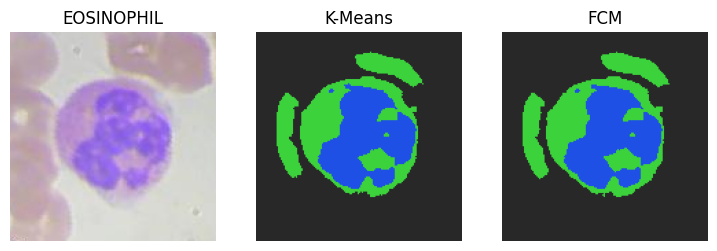

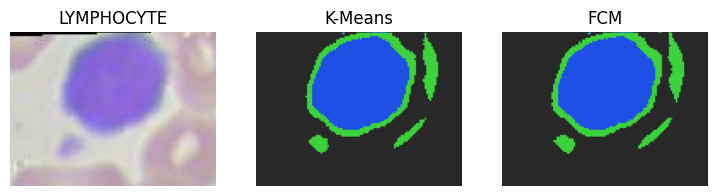

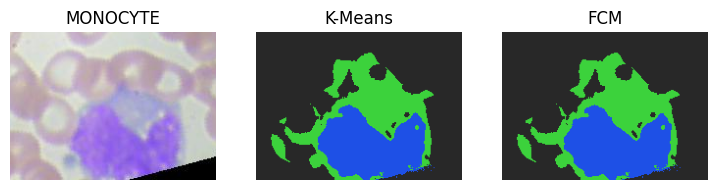

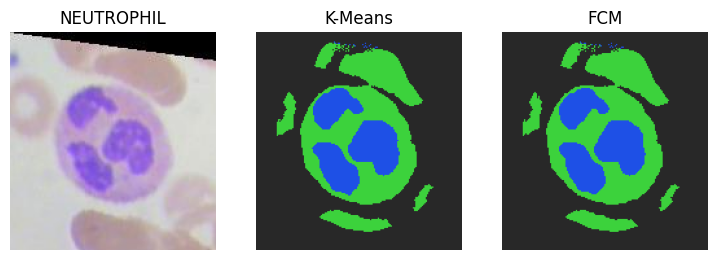

In [43]:
for cell_type,path in sample_paths:

    img=cv2.cvtColor(cv2.imread(path),cv2.COLOR_BGR2RGB) # load
    img=resize(img)
    img_bgr=cv2.cvtColor(img,cv2.COLOR_RGB2BGR)

    wbc,nuc,bbox=detect_wbc(img) # detect
    if wbc is None:
        continue

    r0,r1,c0,c1=bbox # crop
    crop_rgb=img[r0:r1,c0:c1]
    crop_bgr=img_bgr[r0:r1,c0:c1]
    crop_mask=wbc[r0:r1,c0:c1]

    km=kmeans_seg(crop_bgr,crop_mask) # segment
    fcm=fcm_seg(crop_bgr,crop_mask)# segment

    plt.figure(figsize=(9,3)) # display
    plt.subplot(1,3,1); plt.imshow(crop_rgb); plt.axis("off"); plt.title(cell_type)
    plt.subplot(1,3,2); plt.imshow(colorize(km)); plt.axis("off"); plt.title("K-Means")
    plt.subplot(1,3,3); plt.imshow(colorize(fcm)); plt.axis("off"); plt.title("FCM")
    plt.show()

In [44]:
rows=[]
for cell_type,path in sample_paths:  # load
    img=cv2.cvtColor(cv2.imread(path),cv2.COLOR_BGR2RGB)
    img=resize(img)
    img_bgr=cv2.cvtColor(img,cv2.COLOR_RGB2BGR)

    wbc,nuc,bbox=detect_wbc(img) # detect
    if wbc is None:
        continue

    r0,r1,c0,c1=bbox  # crop
    crop_bgr=img_bgr[r0:r1,c0:c1]
    crop_mask=wbc[r0:r1,c0:c1]

    km=kmeans_seg(crop_bgr,crop_mask) # segment
    fcm=fcm_seg(crop_bgr,crop_mask)# segment

    rows.append({    # display
        "cell_type":cell_type,
        "dice":dice(km==2,fcm==2),
        "iou":jaccard(km==2,fcm==2)
    })

pd.DataFrame(rows)

,cell_type,dice,iou
0,EOSINOPHIL,0.998263,0.996532
1,LYMPHOCYTE,0.999790,0.999581
2,MONOCYTE,0.998384,0.996774
3,NEUTROPHIL,0.994861,0.989774



# **Conclusion:**

Both K-Means and Fuzzy C-Means produced nearly identical WBC nucleus–cytoplasm segmentation because the images exhibit clear color separation and low noise, allowing even hard clustering to perform accurately. However, FCM remains theoretically preferable since its soft-membership modeling makes segmentation more robust to gradual stain variations and boundary ambiguity that commonly occur in real microscopic images.

FCM preserves subtle intensity heterogeneity within cellular regions, reduces sensitivity to initialization and local minima, and provides probabilistic membership maps that can support uncertainty analysis and downstream biomedical interpretation.